In [12]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

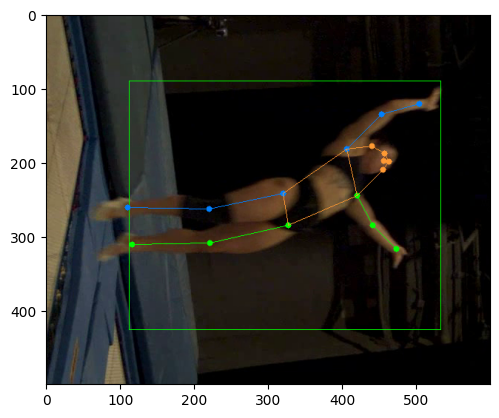

In [13]:
fig, ax = plt.subplots()
img = mpimg.imread('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429_vitL/1_partie_0429_000-Camera7_M11462_vis/vis_frame_00354.png')

cropped_img = img[300:800, 300:900]
ax.imshow(cropped_img)

plt.show()

In [14]:
def load_2d_keypoints(filename):
    # Load JSON file
    with open(filename, "r") as f:
        data = json.load(f)

    if len(data["people"]) > 0:
        coords = []
        conf = []
        for i in range(len(data['people'])):
            keypoints = data["people"][i]["pose_keypoints_2d"]
            keypoints = np.array(keypoints).reshape((-1, 3))

            # Access x, y, and confidence separately if needed
            x_coords = keypoints[:, 0]
            y_coords = keypoints[:, 1]
            confidences = keypoints[:, 2]

            coords.append((x_coords, y_coords))
            conf.append(confidences)

        return coords, conf
    
    return None, None

In [15]:
source_root = '/home/lea/trampo/Pose2Sim/pose_all_vit'

seq = '1_partie_0429_000'
cam_name = 'Camera7_M11462'

frame_idx = 218
frame_name = f'frame_{frame_idx:05d}_{frame_idx:06d}'

img_root = '/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429_vitL/'
img = mpimg.imread(img_root + f'{seq}-{cam_name}_vis/vis_frame_{frame_idx:05d}.png')

folder_name = f"{seq}-{cam_name}_json"
src_path = os.path.join(source_root, folder_name)

keypts, _ = load_2d_keypoints(f'{src_path}/{frame_name}.json')

if keypts is not None:
    keypts = np.array(keypts)
    n_detections = keypts.shape[0]
    keypts = keypts.reshape((n_detections, 2, -1))

In [16]:
vit = ['Nose', 'REye', 'LEye', 'REar', 'LEar', 'RShoulder', 'LShoulder', 'RElbow', 'LElbow',
       'RWrist', 'LWrist', 'RHip', 'LHip', 'RKnee', 'LKnee', 'RAnkle', 'LAnkle']

keypts = keypts.squeeze().T
print(keypts.shape)

(17, 2)


In [17]:
def get_cm_bodypart(x, y, cm_dist):
    xmin, xmax = x
    ymin, ymax = y
    cm = np.array((xmax-xmin, ymax-ymin)) * cm_dist + np.array((xmin, ymin))
    return cm

def compute_global_cm(keypts, bodyparts, cm_distances, masses):
    cm_bodyparts = []
    for bp, cm_dist in zip(bodyparts, cm_distances):
        x = keypts[bp, 0]
        y = keypts[bp, 1]
        cm = get_cm_bodypart(x, y, cm_dist)
        cm_bodyparts.append(cm)

    cm_bodyparts = np.array(cm_bodyparts)
    global_cm = cm = np.sum(np.multiply(cm_bodyparts, masses), axis=0) / masses.sum()

    print('CM:', global_cm)
    return global_cm

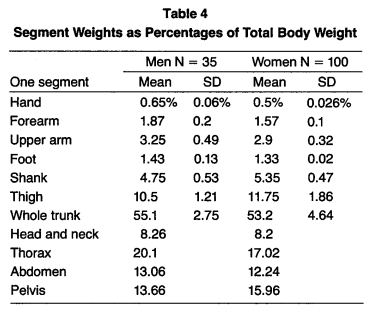
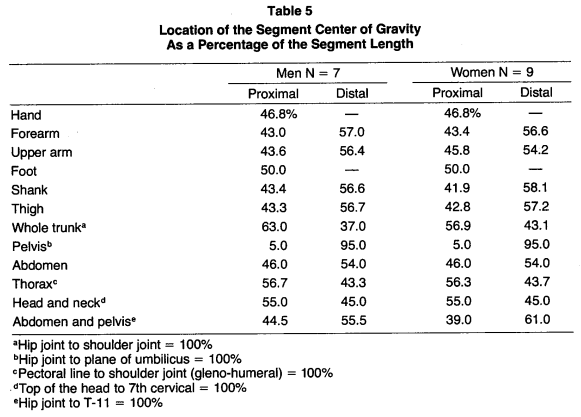

In [19]:
# (proximal, distal) joint indices for each bodypart
# bodyparts : handR, handL, forearmR, forearmL, upperarmR, upperarmL, footR, footL, shankR, shankL, thighR, thighL, trunk, head
bodyparts = [(9,9), (10,10), (7,9), (8,10), (5,7), (6,8), (15,15), (16,16), (13,15), (14,16), (11,13), (12,14), (12,5), (0, 0)]

# --- MEN ---
# proximal proportions of the cm for each bodypart
cm_distances = [0, 0, .43, .43, .436, .436, 0, 0, .434, .434, .433, .433, .63, 0]

# mass proportion of the bodymass for each bodypart
masses = [.0065, .0065, .0187, .0187, .0325, .0325, .0143, .0143, .0475, .0475, .105, .105, .4682, .0826]
print('Total mass for MEN:', np.sum(masses))

# --- WOMEN ---
cm_distances = [0, 0, .434, .434, .458, .458, 0, 0, .419, .419, .428, .428, .569, 0]
masses = [.005, .005, .0157, .0157, .029, .029, .0133, .0133, .0535, .0535, .1175, .1175, .4522, .082]
masses = np.array(masses).reshape((-1, 1))
print('Total mass for WOMEN:', np.sum(masses))
print(len(bodyparts), '=', len(cm_distances), '=', len(masses), 'bodyparts')

global_cm = compute_global_cm(keypts, bodyparts, cm_distances, masses)

# validate implementation in CoM class
from compute_CoM import CoM
com = CoM('women')
cm = com.compute_global_cm(keypts)
print(cm)

Total mass for MEN: 0.9998
Total mass for WOMEN: 1.0022
14 = 14 = 14 bodyparts
CM: [1406.42269677  499.14218392]
CM: [1406.42269677  499.14218392]
[1406.42269677  499.14218392]


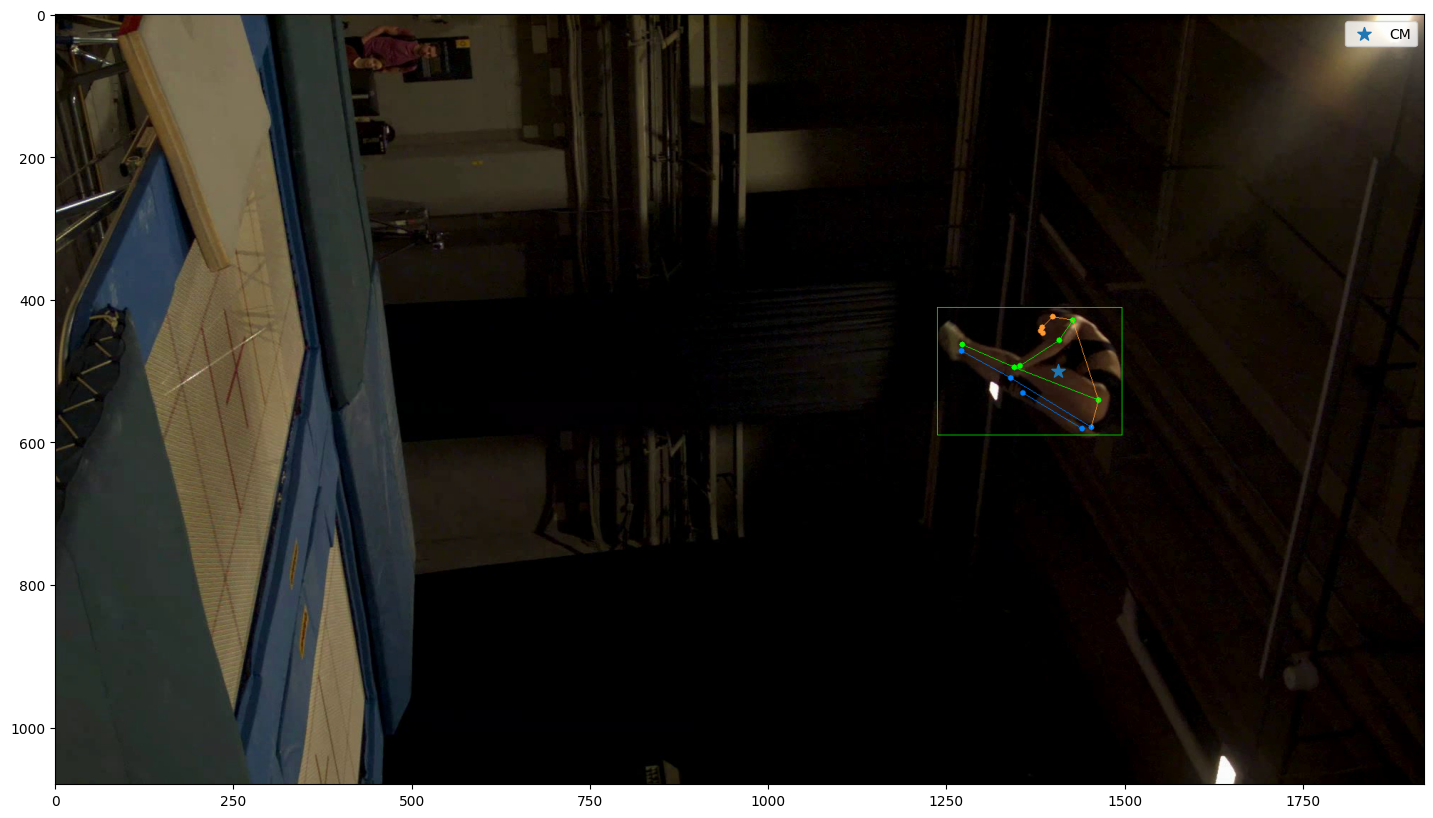

In [20]:
fig, ax = plt.subplots(figsize=(19,10))
ax.imshow(img)
plt.scatter(*global_cm, marker='*', s=100, label='CM')
plt.legend()
plt.show()